In [86]:
import numpy as np
import matplotlib.pyplot as plt

gamma = 2

def log_sum_exp(x_k):
    return np.log(np.sum(np.exp(x_k/gamma)))

def W(x):

    w = np.zeros(len(x))
    
    len_x = np.size(x)
    
    
    for i in range(len(x)//3):
            t = log_sum_exp(np.array([x[i], x[i+1]]))
            t2 = log_sum_exp(np.array([-x[i],-x[i+1]]))
            t3 = log_sum_exp(np.array([x[i+len_x//2], x[i+1+len_x//2]]))
            t4 = log_sum_exp(np.array([-x[i+len_x//2], -x[i+1+len_x//2]]))
            w[i] = t + t2 + t3 + t4
        
    return gamma*(np.sum(w))

def grad_W(x):
    
    len_x = np.size(x)
    #flattened_v_pair = v_pair_in.flatten()
    #unique, counts = np.unique(flattened_v_pair, return_counts=True)
    grad_x = np.zeros(len_x//2)
    grad_y = np.zeros(len_x//2)
    
    grad_x[0] = ( np.exp(x[0]/gamma)/(np.exp(x[0]/gamma) + np.exp(x[0+1]/gamma)) ) - (np.exp(-x[0]/gamma)/(np.exp(-x[0]/gamma) + np.exp(-x[0+1]/gamma)))
    
    grad_x[1] = ( np.exp(x[1]/gamma)/(np.exp(x[1]/gamma) + np.exp(x[1+1]/gamma)) ) - (np.exp(-x[1]/gamma)/(np.exp(-x[1]/gamma) + np.exp(-x[1+1]/gamma))) + ( np.exp(x[1]/gamma)/(np.exp(x[1]/gamma) + np.exp(x[1-1]/gamma)) ) - (np.exp(-x[1]/gamma)/(np.exp(-x[1]/gamma) + np.exp(-x[1-1]/gamma)))
    
    grad_x[2] = ( np.exp(x[2]/gamma)/(np.exp(x[2]/gamma) + np.exp(x[2-1]/gamma)) ) - (np.exp(-x[2]/gamma)/(np.exp(-x[2]/gamma) + np.exp(-x[2-1]/gamma)))
    
#    for i in unique:
#        if counts[i] == 1 and i == 0:
#            grad_x[i] = np.exp(x[i])/(np.exp(x[i]) + np.exp(x[i+1])) - np.exp(-x[i])/(np.exp(-x[i]) + np.exp(-x[i+1]))
#        elif counts[i] == 1 and i == 2:
#            grad_x[i] = np.exp(x[i])/(np.exp(x[i]) + np.exp(x[i-1])) - np.exp(-x[i])/(np.exp(-x[i]) + np.exp(-x[i-1]))
#        else:
#            mult = [1, -1]
#            for j in range(counts[i]):
#                grad_x[i] = grad_x[i] + np.exp(x[i])/(np.exp(x[i])+np.exp(x[i-1*(mult[j])])) - np.exp(-x[i])/(np.exp(-x[i]) + np.exp(-x[i-1*mult[j]]))
               
  # for i in unique:
  #     if counts[i] == 1 and i == 0:
  #         grad_y[i] = np.exp(y[i]/gamma)/(np.exp(y[i]/gamma) + np.exp(y[i+1]/gamma)) - np.exp(-y[i]/gamma)/(np.exp(-y[i]/gamma) + np.exp(-y[i+1]/gamma))
  #     elif counts[i] == 1 and i == 2:
  #         grad_y[i] = np.exp(y[i]/gamma)/(np.exp(y[i]/gamma) + np.exp(y[i-1]/gamma)) - np.exp(-y[i]/gamma)/(np.exp(-y[i]/gamma) + np.exp(-y[i-1]/gamma))
  #     else:
  #         mult = [1, -1]
  #         for j in range(counts[i]):
  #             grad_y[i] = grad_y[i] + np.exp(y[i]/gamma)/(np.exp(y[i]/gamma)+np.exp(y[i-1*(mult[j])]/gamma)) - np.exp(-y[i]/gamma)/(np.exp(-y[i]/gamma) + np.exp(-y[i-1*mult[j]]/gamma))
                
    grad_y[0] = ( np.exp(x[0+len_x//2]/gamma)/(np.exp(x[0+len_x//2]/gamma) + np.exp(x[0+1+len_x//2]/gamma)) ) - (np.exp(-x[0+len_x//2]/gamma)/(np.exp(-x[0+len_x//2]/gamma) + np.exp(-x[0+1+len_x//2]/gamma)))
    
    grad_y[1] = ( np.exp(x[1+len_x//2]/gamma)/(np.exp(x[1+len_x//2]/gamma) + np.exp(x[1+1+len_x//2]/gamma)) ) - (np.exp(-x[1+len_x//2]/gamma)/(np.exp(-x[1+len_x//2]/gamma) + np.exp(-x[1+1+len_x//2]/gamma))) + ( np.exp(x[1+len_x//2]/gamma)/(np.exp(x[1+len_x//2]/gamma) + np.exp(x[1-1+len_x//2]/gamma)) ) - (np.exp(-x[1+len_x//2]/gamma)/(np.exp(-x[1+len_x//2]/gamma) + np.exp(-x[1-1+len_x//2]/gamma)))
    
    grad_y[2] = ( np.exp(x[2+len_x//2]/gamma)/(np.exp(x[2+len_x//2]/gamma) + np.exp(x[2-1+len_x//2]/gamma)) ) - (np.exp(-x[2+len_x//2]/gamma)/(np.exp(-x[2+len_x//2]/gamma) + np.exp(-x[2-1+len_x//2]/gamma)))
                
    grad_w = np.concatenate((grad_x, grad_y))  
    #print(grad_w)
    return grad_w, grad_x, grad_y
            

def a(wv,wb):
    return 4/((wv + 2*wb)*(wv + 4*wb))
def b(wv,wb):
    return 2/(wb*(wv+4*wb))

def P(x,wv,wb):
    
    if not np.isscalar(x):
        raise ValueError("Input x (or y) should be a scalar in Px and Py in this iteration of the program.")
        
    if 0 <= x <= (wv / 2 + wb):
        return 1 - a(wv,wb)*(x**2)
    elif (wv / 2 + wb) <= x <= (wv / 2 + 2 * wb):
        return b(wv,wb)*(x - wv/2 - 2*wb)^2
    elif x >= (wv/2+2*wb):
        return 0
    
def D(x,y,a):
    wb = 2
    hb = 2
    t_den = 0.6
    d = np.zeros(len(x))
    for i in range(len(x)):
        d[i] = P(x[i],v_width[i],wb)*P(y[i],v_height[i],hb)
    cv = a / d
    return np.sum(cv*d - t_den*wb*hb)

def sum_bin(x,y,a):
    
    lambda_ = 1
    bin_ = np.zeros(num_bins)
    for i in range(num_bins):
        bin_[i] = D(x,y,a)
        
    return lambda_*np.sum(bin_)
    
        

3.0
11.5366729970246
-5.325482657645545
h: 1.000e+00, 	 err0: 8.968e-01, 	 err1: 4.454e-01
h: 5.000e-01, 	 err0: 3.398e-01, 	 err1: 1.140e-01
h: 2.500e-01, 	 err0: 1.417e-01, 	 err1: 2.879e-02
h: 1.250e-01, 	 err0: 6.366e-02, 	 err1: 7.230e-03
h: 6.250e-02, 	 err0: 3.003e-02, 	 err1: 1.811e-03
h: 3.125e-02, 	 err0: 1.456e-02, 	 err1: 4.532e-04
h: 1.562e-02, 	 err0: 7.167e-03, 	 err1: 1.134e-04
h: 7.812e-03, 	 err0: 3.555e-03, 	 err1: 2.835e-05
h: 3.906e-03, 	 err0: 1.771e-03, 	 err1: 7.088e-06
h: 1.953e-03, 	 err0: 8.835e-04, 	 err1: 1.772e-06
h: 9.766e-04, 	 err0: 4.413e-04, 	 err1: 4.430e-07
h: 4.883e-04, 	 err0: 2.205e-04, 	 err1: 1.108e-07
h: 2.441e-04, 	 err0: 1.102e-04, 	 err1: 2.769e-08
h: 1.221e-04, 	 err0: 5.511e-05, 	 err1: 6.923e-09
h: 6.104e-05, 	 err0: 2.756e-05, 	 err1: 1.731e-09
h: 3.052e-05, 	 err0: 1.378e-05, 	 err1: 4.327e-10
h: 1.526e-05, 	 err0: 6.889e-06, 	 err1: 1.082e-10
h: 7.629e-06, 	 err0: 3.444e-06, 	 err1: 2.704e-11
h: 3.815e-06, 	 err0: 1.722e-06, 	 err1: 6

(array([1.e-18, 1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04,
        1.e-02, 1.e+00, 1.e+02, 1.e+04]),
 [Text(0, 1e-18, '$\\mathdefault{10^{-18}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$'),
  Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'),
  Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'),
  Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$')])

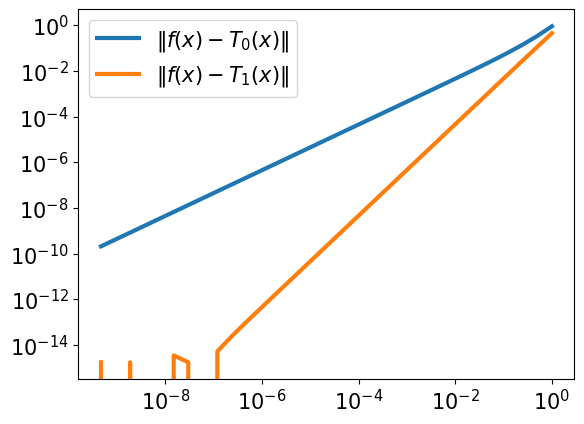

In [87]:
dim = 3
num_edges = 2
num_bins = 1

block_min_width = 0.5
block_max_width = 1

bin_min = 0
bin_max = 2

v_width = np.random.uniform(block_min_width, block_max_width, dim)
v_height = np.random.uniform(block_min_width, block_max_width, dim)

v_area = v_width*v_height

x0 = np.random.uniform(bin_min,bin_max,dim)
y0 = np.random.uniform(bin_min,bin_max,dim)
v_x = np.random.randn(dim)
v_y = np.random.randn(dim)
v_stack = np.vstack((v_x,v_y))
v_concat = np.concatenate((v_x,v_y))

x_len = len(x0)
x = np.concatenate((x0,y0))

len_x = len(x)
print(len_x/2)

#vertex pair indices
v_pair_ind = np.array([[0, 1],[1,2]])


print(W(x))
print(D(x0,y0,v_area))


max_iters = 32
h = np.zeros(max_iters)
err0 = np.zeros(max_iters)
err1 = np.zeros(max_iters)

for i in range(max_iters):
  h[i] = 2**(-i) # halve our stepsize every time

  fv = W(x + h[i]*v_concat)
  T0 = W(x)
  
  [grad_w, grad_x, grad_y] = grad_W(x)
  
  T1 = T0 + h[i]*np.matmul(grad_w.T, v_concat)

  err0[i] = np.linalg.norm(fv - T0) # this error should be linear
  err1[i] = np.linalg.norm(fv - T1) # this error should be quadratic

  # print('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])

  print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))
  

plt.loglog(h, err0, linewidth=3)
plt.loglog(h, err1, linewidth=3)
plt.legend([r'$\|f(x) - T_0(x)\|$', r'$\|f(x)-T_1(x)\|$'], fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [88]:
def f(x,v_pair_ind):
    return W(x,v_pair_ind)

def grad_f(x,v_pair_ind):
    return grad_W(x,v_pair_ind)

def armijo(a_0, pk, xk):
    """
    Auxiliary function to perform Armijo backtracking to obtain a step length alpha_k that leads to
    convergence, i.e. satisfies the Wolfe Conditions

    Parameters:
        a_0: Initial guess for step length (1.0)
        pk: Descent direction
        xk: Value of x at current iteration

    Return:
        alpha: Step length that satisfies Wolfe Conditions
    """
    alpha = a_0
    rho = 0.5#Needs to be between 0 and 1
    c1 = 0.25
    while (f(xk + alpha*pk) > f(xk) + alpha*c1*np.dot(grad_f(xk), pk)):
        alpha = rho*alpha
        
    return alpha
    
def bfgs(x0, H0, eps=1.0e-3):
    """
    Parameters:
        x0: Initial guess for trajectory being minimized x
        H0: Initial guess for approximate Hessian

    Return:
        x_new: Minimized trajectory x(t)
        f_vals: Values of f(x(t)) at each iteration
        grad_norms: values of del(f(x(t))) at each iteration
    """
    #Re-use x_prev is x_k in BFGS iteration, x_new is x_k+1, Hk is approximate inverse of del^2 f(x)
    k = 0
    x_prev = x0
    Hk = H0
    Hk1 = H0
    x_new = x0
    f_vals = []
    f_vals.append(f(x_prev))
    grad_norms = []
    grad_norms.append(np.linalg.norm(grad_f(x_prev)))
    while(np.linalg.norm(grad_f(x_prev)) >= eps):
        grad_f_p = grad_f(x_prev)
        print("Iteration " + str(k) + ":        f(x_k): " + str(f(x_prev)) + "        ||grad_f(x_k)||_2: " + str(np.linalg.norm(grad_f_p)))
        pk = -Hk@grad_f_p#Descent direction
        ak = armijo(1.0, pk, x_prev)#Armijo backtracking routine to find alpha_k that will lead to convergence
        x_new = x_prev + ak*pk
        sk = x_new - x_prev
        grad_f_n = grad_f(x_new)
        yk = grad_f_n - grad_f_p
        rho_k = 1.0/np.dot(yk,sk)
        #Expand BFGS update formula 6.17 in Ch.6 of Nocedal and write to calculate H_k+1 using only matrix addition,
        #matrix-vector products and outer products of vectors so total time complexity of update is O(n^2)
        uk = Hk@yk
        vk = (Hk.T)@yk
        Hk1 = Hk - rho_k*np.outer(sk,vk) - rho_k*np.outer(uk,sk) + ((rho_k**2)*np.dot(yk,uk))*np.outer(sk,sk) + rho_k*np.outer(sk,sk)
        f_vals.append(f(x_new))
        grad_norms.append(np.linalg.norm(grad_f(x_new)))
        x_prev = x_new
        Hk = Hk1
        k += 1
    return x_new, f_vals, grad_norms